In [272]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt

# Environment

In [273]:

class Environment:
    def __init__(self, f):
        self.file = f
        self.lines = self.convert_file()
        self.cliff = self.build_cliff()
        self.rmap = { "0" : -100, "1" : -1, "f" : -1, "s" : -1 }
    
    def convert_file(self):
        lines = []
        with open(self.file) as f:
            lines = f.readlines()
        return lines
    
    def build_cliff(self):
        cliff = []
        for i in range(len(self.lines)):
            level = []
            for j in range(len(self.lines[i])):
                if self.lines[i][j] != '\n':
                    level.extend(self.lines[i][j])
            cliff.append(level)
        return np.asarray(cliff)

    def get_cliff(self):
        return self.cliff
    
    def print_env(self):
        for l in self.lines:
            print(l, end="")
    
    def get_start(self):
        # returns the starting position
        # here, there is only one possibility
        ixs = np.argwhere(self.cliff=='s').tolist()
        i = np.random.choice(len(ixs), 1)
        s = ixs[i[0]]
        self.start = s
        return self.start

    def stepped_off_cliff(self, x, y):
        # checks whether the agent is stepping off the 
        # cliff with the current action
        return self.cliff[x][y] == '0'

    def stepped_out_of_bounds(self, x, y):
        if x<0 or y<0 or x>=len(self.cliff) or y>=len(self.cliff[0]):
            return True
        return False 
    
    def finished(self, x, y):
        return self.cliff[x][y] == 'f'
    
    def get_reward(self, x, y):
        mpos = self.cliff[x][y]
        return self.rmap[mpos]
        

# Agent

In [274]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.s = env.get_start()
        self.x = self.s[0]
        self.y = self.s[1]
        self.a = [[1,0], [0,1], [-1,0], [0,-1]]
    
    def get_actions(self):
        return self.a
    
    def reset_agent(self):
        self.s = self.env.get_start()
    
    def get_start(self):
        self.s = self.env.get_start()
        return self.s
    
    def get_valid_actions(self, x, y):
        # valid is defined here as those actions where you
        # don't go out of bounds
        alist = []
        for a in self.a:
            nx = x - a[0]
            ny = y + a[1]
            # ensure that the new x and new y are not out 
            # of the array bounds
            if not self.env.stepped_out_of_bounds(nx, ny):
                alist.append(a)
        return alist
        

# SARSA

In [378]:
class SARSA:
    def __init__(self, epsilon, discount_rate, learning_rate, agent, environment, episodes, runs):
        self.e = epsilon
        self.d = discount_rate
        self.l = learning_rate
        self.env = environment
        self.agent = agent
        self.runs = runs
        self.episodes = episodes
        self.episode = {}              # e[t] = (s, r), where s or state is (x, y) and r is reward
        self.Q = self.initialize()     # Q[s] = q, where s includes both state and action information
                                       #           as a tuple (x, y, change_to_x, change_to_y)
    
    def initialize(self):
        # by default sets all Q values to 0
        d = {}
        for x in range(len(self.env.get_cliff())):
            for y in range(len(self.env.get_cliff()[x])):
                for a in self.agent.get_actions():
                    dx, dy = a[0], a[1]
                    s = [x, y, dx, dy]
                    d[tuple(s)] = 0
        return d


    def get_next_action(self, x, y):
        if(np.random.binomial(1, self.e)): # 1 if exploring, 0 if exploiting
            # valid here means not out of the bounds of the array
            #   but we still need to check whether it is "off the cliff"Agent
            #   incurring the -100 reward/penalty
            valid_actions = self.agent.get_valid_actions(x, y)
            exploring =  valid_actions[random.randint(0, len(valid_actions))-1]
            return exploring[0], exploring[1], "exploring"
        a = self.get_greedy_action(x, y) # state returned has form (x, y)
        return a[0], a[1], "greedy" # dx, dy
    

    def get_greedy_action(self, x, y):
        sas = [tuple([x, y, a[0], a[1]]) for a in self.agent.get_valid_actions(x, y)] 
        subset_dict = {k:v for k, v in self.Q.items() if k in sas} # subset dict to keys
        idxs = max(subset_dict, key=subset_dict.get) # return key for max value
        return idxs[-2:] # return (dx, dy) from (x, y, dx, dy)
    
    
    def update_state(self, old_x, old_y, old_dx, old_dy):
        r = -1 # set default reward
        # update state
        new_x = old_x - old_dx # subtract because going up means reducing index
        new_y = old_y + old_dy
        # check whether (x,y) is out of array bounds or "off the cliff"
        if self.env.stepped_out_of_bounds(new_x, new_y) or self.env.stepped_off_cliff(new_x, new_y):
            s = self.env.get_start()
            new_x, new_y = s[0], s[1]
            r = -100
        return new_x, new_y, r


    def update_q(self, old_x, old_y, old_dx, old_dy, new_x, new_y, new_dx, new_dy, r):
        # s, s'
        old_sa = tuple([old_x, old_y, old_dx, old_dy])
        new_sa = tuple([new_x, new_y, new_dx, new_dy])
        # set target
        target = r + (self.d * self.Q[new_sa])
        # make on policy update
        #   it is on policy because the key (state, action pair) where we update the q function
        #   is the same as the one that generated the action
        oldq = self.Q[old_sa]
        self.Q[old_sa] = oldq + self.l*(target - oldq)

    
    def run(self, r=1, e=1):
        i = r
        episodes_in_run = []
        while i != 0: 
            cr_by_episode = [] # appended to 500 times
            j = e
            while j != 0:
                self.episode = {}
                t = 0
                tr = 0
                s = self.agent.get_start() 
                x, y = s[0], s[1]
                dx, dy, _ = self.get_next_action(x, y) 
                while(not self.env.finished(x, y)):
                    old_x, old_y, old_dx, old_dy = x, y, dx, dy
                    x, y, r = self.update_state(old_x, old_y, old_dx, old_dy)
                    dx, dy, _ = self.get_next_action(x, y)
                    self.update_q(old_x, old_y, old_dx, old_dy, x, y, dx, dy, r) 
                    self.episode[t] = ((old_x, old_y, old_dx, old_dy), r)
                    t += 1
                    tr += r
                cr_by_episode.append([tr])
                self.episode[t] = ((x, y, dx, dy), r)
                j -= 1
            episodes_in_run.append(cr_by_episode)
            i -= 1
        return self.episode, episodes_in_run # return the last episode created
    

    def change_env(self, env):
        # changed environemnt to use experimentally
        self.env = env


    def DEBUG_PRINT(self, timestep, old_x, old_y, old_dx, old_dy, x, y, dx, dy, atype):
        # [0] print time step
        print(timestep)

        # [1] details about state-action update
        print(f"{old_x, old_y} and {old_dx, old_dy} -> {x, y} and {dx, dy}")

        # [2] details about action
        #   whether greedy or exploratory
        #   what q key-value pairs it was selected from
        sa_pairs = [(old_x, old_y, _dx, _dy) 
                    for _dx, _dy 
                    in self.agent.get_valid_actions(old_x, old_y)]
        qvalues = [(sa, self.Q[sa]) for sa in sa_pairs]
        print(f"{dx, dy} action selected was {atype} from {qvalues}")

        # new line to indicate new episode
        print()
    

    def __call__(self):
        episodes_in_run = []
        for r in range(self.runs): # 50
            self.Q = self.initialize() 
            cr_by_episode = []

            # Main loop
            #   Each episode ends when the agent's position (x, y)
            #   is at the finish state.
            #   
            #   Episode starts with (x, y, dx, dy) - an initial position
            #   an an initial action. The q value for this state-action
            #   pair is based on the q value of the very next state and
            #   the reward we get in this state.
            for e in range(self.episodes): # 500
                self.episode = {}
                t = 0
                r = 0
                tr = r

                # state
                s = self.agent.get_start() 
                x, y = s[0], s[1]

                # action
                dx, dy, atype = self.get_next_action(x, y) 

                while(not self.env.finished(x, y)):
                    old_x, old_y, old_dx, old_dy = x, y, dx, dy
                    x, y, r = self.update_state(old_x, old_y, old_dx, old_dy)
                    dx, dy, atype = self.get_next_action(x, y)
                    self.update_q(old_x, old_y, old_dx, old_dy, x, y, dx, dy, r) 
                    self.episode[t] = ((old_x, old_y, old_dx, old_dy), r)
                    # self.DEBUG_PRINT(t, old_x, old_y, old_dx, old_dy, x, y, dx, dy, atype)
                    t += 1
                    tr += r
                cr_by_episode.append([tr])
                self.episode[t] = ((x, y, dx, dy), r)
            episodes_in_run.append(cr_by_episode) # outer dimension should be 10, with inner dimension 500
        return episodes_in_run


In [355]:
class GridWorldViz:
    def __init__(self, RL_learner):
        self.RL = RL_learner
        self.dimension = self.RL.env.cliff.shape
        self.dirmap = { (1, 0) : "[^]", 
                        (0, 1) : "[>]", 
                        (-1, 0) : "[v]", 
                        (0, -1) : "[<]" }
         
    def draw_policy(self):
        '''Print out cliff world with the optimal actions (left, right, up, down)
        overlaid on each state in the gridworld.
        '''
        # for each state, gets the action that produces the max value
        # actions are mapped as follows
        # dx  dy
        # ------
        # [1, 0]  is > (right)
        # [0, 1]  is v (down)
        # [-1, 0] is < (left)
        # [0, -1] is ^ (up)
        #
        # the character for the direction is placed within "[" and "]" 
        
        maxx = self.dimension[0]
        maxy = self.dimension[1]
        for x in range(maxx):
            row = []
            for y in range(maxy):
                # get the greedy action
                ga = self.RL.get_greedy_action(x, y)
                if self.RL.env.cliff[x][y] != '0':
                    row.append(self.dirmap[tuple(ga)])
                # do not append a direction if it is the cliff
                else:
                    row.append("[ ]")
            print(''.join(row))
    
    def draw_episode(self, episode):
        # built dict with movement boxes
        # key is position, value is the movement box
        d = { sa[0][:-2] : self.dirmap[sa[0][-2:]] for sa in episode.values() }
        maxx = self.dimension[0]
        maxy = self.dimension[1]
        for x in range(maxx):
            row = []
            for y in range(maxy):
                if (x,y) in d.keys():
                    row.append(d[(x,y)])
                else:
                    row.append("[ ]")
            print(''.join(row))

In [480]:
f = "env.txt"
epsilon = 0.1
discount_rate = 0.9
learning_rate = 0.7
runs = 50
episodes = 500
env = Environment(f)
agent = Agent(env)

In [481]:
sarsa = SARSA(epsilon=epsilon,
              discount_rate=discount_rate,
              learning_rate=learning_rate,
              runs=runs,
              episodes=episodes,
              environment=env,
              agent=agent)

In [482]:
sarsa.env.print_env()

111111111111
111111111111
111111111111
s0000000000f


In [483]:
sarsa_runs = sarsa()

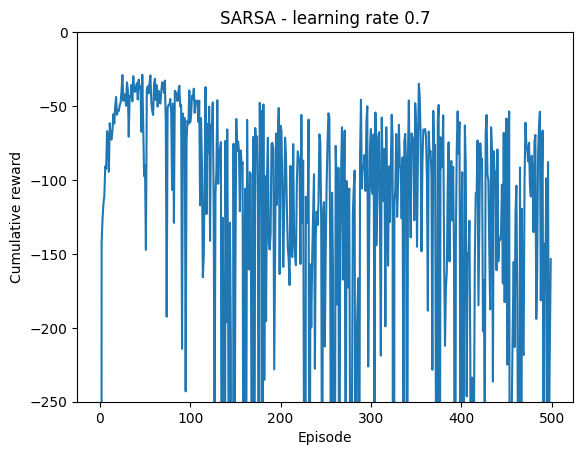

In [484]:
x = range(0, len(sarsa_runs[0])) # 500
y = np.average(np.asarray(sarsa_runs), axis=0)

plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.title(f"SARSA - learning rate {learning_rate}")
plt.ylim(-250, 0)
plt.plot(x,y);

In [361]:
sarsa_viz = GridWorldViz(sarsa)

In [362]:
sarsa_viz.draw_policy()

[>][>][>][>][>][>][>][>][>][>][>][v]
[>][>][>][>][>][>][>][>][>][>][>][v]
[^][^][^][>][^][^][^][^][>][>][>][v]
[^][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][^]


In [363]:
sarsa_op, _ = sarsa.run() # runs an episode with the establish q table
sarsa_viz.draw_episode(sarsa_op)

i 1
j 1
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[>][>][>][>][>][>][>][>][>][>][>][v]
[^][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][v]
[^][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][^]


# Q-Learning

In [418]:
class QLearning:
    def __init__(self, epsilon, discount_rate, learning_rate, agent, environment, episodes, runs):
        self.e = epsilon
        self.d = discount_rate
        self.l = learning_rate
        self.env = environment
        self.agent = agent
        self.runs = runs
        self.episodes = episodes
        self.episode = {}              # e[t] = (s, r), where s or state is (x, y) and r is reward
        self.Q = self.initialize()     # Q[s] = q, where s includes both state and action information
                                       #           as a tuple (x, y, change_to_x, change_to_y)
    
    def initialize(self):
        # by default sets all Q values to 0
        d = {}
        for x in range(len(self.env.get_cliff())):
            for y in range(len(self.env.get_cliff()[x])):
                for a in self.agent.get_actions():
                    dx, dy = a[0], a[1]
                    s = [x, y, dx, dy]
                    d[tuple(s)] = 0
        return d


    def get_next_action(self, x, y):
        if(np.random.binomial(1, self.e)): # 1 if exploring, 0 if exploiting
            # valid here means not out of the bounds of the array
            #   but we still need to check whether it is "off the cliff"Agent
            #   incurring the -100 reward/penalty
            valid_actions = self.agent.get_valid_actions(x, y)
            exploring =  valid_actions[random.randint(0, len(valid_actions))-1]
            return exploring[0], exploring[1], "exploring"
        a = self.get_greedy_action(x, y) # state returned has form (x, y)
        return a[0], a[1], "greedy" # dx, dy
    

    def get_greedy_action(self, x, y):
        sas = [tuple([x, y, a[0], a[1]]) for a in self.agent.get_valid_actions(x, y)] 
        subset_dict = {k:v for k, v in self.Q.items() if k in sas} # subset dict to keys
        idxs = max(subset_dict, key=subset_dict.get) # return key for max value
        return idxs[-2:] # return (dx, dy) from (x, y, dx, dy)
    
    
    def update_state(self, old_x, old_y, old_dx, old_dy):
        r = -1 # set default reward
        # update state
        new_x = old_x - old_dx # subtract because going up means reducing index
        new_y = old_y + old_dy
        # check whether (x,y) is out of array bounds or "off the cliff"
        if self.env.stepped_out_of_bounds(new_x, new_y) or self.env.stepped_off_cliff(new_x, new_y):
            s = self.env.get_start()
            new_x, new_y = s[0], s[1]
            r = -100
        return new_x, new_y, r


    def update_q(self, old_x, old_y, old_dx, old_dy, new_x, new_y, new_dx, new_dy, r):
        # s, s'
        old_sa = tuple([old_x, old_y, old_dx, old_dy])
        new_sa = tuple([new_x, new_y, new_dx, new_dy])
        # set target
        target = r + (self.d * self.Q[new_sa])
        # make on policy update
        #   it is on policy because the key (state, action pair) where we update the q function
        #   is the same as the one that generated the action
        oldq = self.Q[old_sa]
        self.Q[old_sa] = oldq + self.l*(target - oldq)
    
    def run(self, r=1, e=1):
        i = r
        episodes_in_run = []
        while i != 0: 
            cr_by_episode = [] # appended to 500 times
            j = e
            while j != 0:
                self.episode = {}
                t = 0
                tr = 0
                s = self.agent.get_start() 
                x, y = s[0], s[1]
                dx, dy, _ = self.get_next_action(x, y) 
                while(not self.env.finished(x, y)):
                    old_x, old_y, old_dx, old_dy = x, y, dx, dy
                    x, y, r = self.update_state(old_x, old_y, old_dx, old_dy)
                    dx, dy, _ = self.get_next_action(x, y)
                    # we pass the greedy action (greedy_dx, greedy_dy) to update_q() rather than
                    # the policy's dx, dy we get above
                    greedy_dx, greedy_dy = self.get_greedy_action(x, y)
                    self.update_q(old_x, old_y, old_dx, old_dy, x, y, greedy_dx, greedy_dy, r) 
                    self.episode[t] = ((old_x, old_y, old_dx, old_dy), r)
                    t += 1
                    tr += r
                cr_by_episode.append([tr])
                self.episode[t] = ((x, y, dx, dy), r)
                j -= 1
            episodes_in_run.append(cr_by_episode)
            i -= 1
        return self.episode, episodes_in_run # return the last episode created


    def change_env(self, env):
        # changed environemnt to use experimentally
        self.env = env


    def DEBUG_PRINT(self, timestep, old_x, old_y, old_dx, old_dy, x, y, dx, dy, atype):
        # [0] print time step
        print(timestep)

        # [1] details about state-action update
        print(f"{old_x, old_y} and {old_dx, old_dy} -> {x, y} and {dx, dy}")

        # [2] details about action
        #   whether greedy or exploratory
        #   what q key-value pairs it was selected from
        sa_pairs = [(old_x, old_y, _dx, _dy) 
                    for _dx, _dy 
                    in self.agent.get_valid_actions(old_x, old_y)]
        qvalues = [(sa, self.Q[sa]) for sa in sa_pairs]
        print(f"{dx, dy} action selected was {atype} from {qvalues}")

        # new line to indicate new episode
        print()
    

    def __call__(self):
        episodes_in_run = []
        for r in range(self.runs): # 50
            self.Q = self.initialize() 
            cr_by_episode = []

            # The difference between the main loop in q-learning and in sarsa is
            #   in how the update to the action value (q) is made. In sarsa, it 
            #   is made using s', a' using the same policy; in q-learning, we
            #   make the update using not s', a' but the state-action pair that
            #   has the highest q value so far - i.e., we follow a different 
            #   policy where we are greedy.
            for e in range(self.episodes): # 500
                self.episode = {}
                t = 0
                r = 0
                tr = r

                # state
                s = self.agent.get_start() 
                x, y = s[0], s[1]

                # action
                dx, dy, atype = self.get_next_action(x, y) 

                while(not self.env.finished(x, y)):
                    old_x, old_y, old_dx, old_dy = x, y, dx, dy
                    x, y, r = self.update_state(old_x, old_y, old_dx, old_dy)
                    dx, dy, atype = self.get_next_action(x, y)
                    # we pass the greedy action (greedy_dx, greedy_dy) to update_q() rather than
                    # the policy's dx, dy we get above
                    greedy_dx, greedy_dy = self.get_greedy_action(x, y)
                    self.update_q(old_x, old_y, old_dx, old_dy, x, y, greedy_dx, greedy_dy, r) 
                    self.episode[t] = ((old_x, old_y, old_dx, old_dy), r)
                    # self.DEBUG_PRINT(t, old_x, old_y, old_dx, old_dy, x, y, dx, dy, atype)
                    t += 1
                    tr += r
                cr_by_episode.append([tr])
                self.episode[t] = ((x, y, dx, dy), r)
            episodes_in_run.append(cr_by_episode) # outer dimension should be 10, with inner dimension 500
        return episodes_in_run


In [460]:
f = "env.txt"
epsilon = 0.1
discount_rate = 0.9
learning_rate = 0.9
runs = 50
episodes = 500
env = Environment(f)
agent = Agent(env)

In [461]:
ql = QLearning(epsilon=epsilon,
              discount_rate=discount_rate,
              learning_rate=learning_rate,
              runs=runs,
              episodes=episodes,
              environment=env,
              agent=agent)

In [462]:
ql.env.print_env()

111111111111
111111111111
111111111111
s0000000000f


In [463]:
ql_runs = ql()

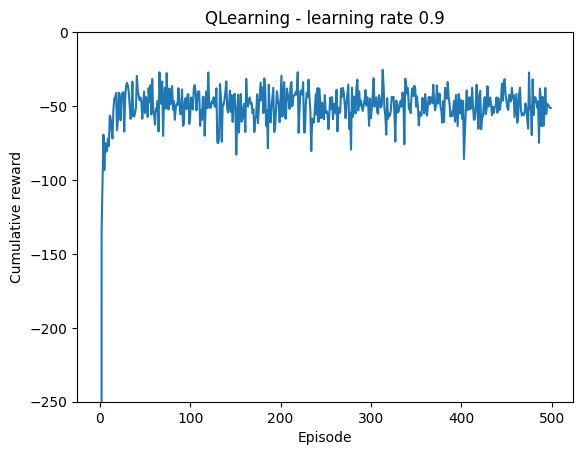

In [464]:
x = range(0, len(ql_runs[0])) # 500
y = np.average(np.asarray(ql_runs), axis=0)

plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.title(f"QLearning - learning rate {learning_rate}")
plt.ylim(-250, 0)
plt.plot(x,y)

In [424]:
ql_viz = GridWorldViz(ql)

In [425]:
ql_viz.draw_policy()

[>][>][>][>][>][>][>][<][>][>][v][v]
[>][>][v][>][v][v][>][>][>][>][v][v]
[>][>][>][>][>][>][>][>][>][>][>][v]
[^][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][^]


In [426]:
ql_op, _ = ql.run()

In [427]:
ql_viz.draw_episode(ql_op) # 0.5 learning rate produces the expected path

[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[>][>][>][>][>][>][>][>][>][>][>][v]
[^][ ][ ][ ][ ][ ][ ][ ][ ][ ][ ][^]


# SARSA to Q-Learning Comparison

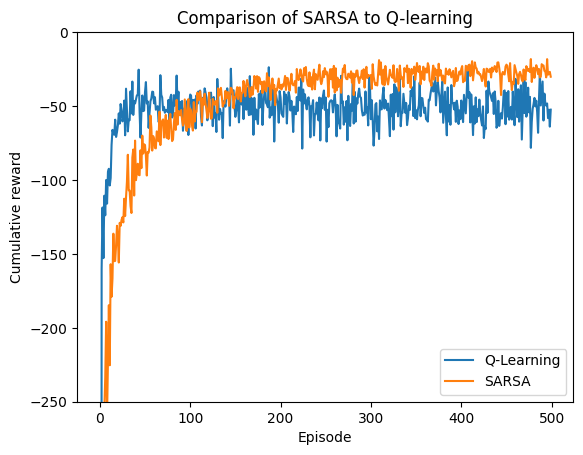

In [428]:
x = range(0, len(sarsa_runs[0])) # 500
sarsa = np.average(np.asarray(sarsa_runs), axis=0)
ql = np.average(np.asarray(ql_runs), axis=0)

plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.title(f"Comparison of SARSA to Q-learning")
plt.ylim(-250, 0)
plt.plot(x, ql, label="Q-Learning")
plt.plot(x, sarsa, label="SARSA")
plt.legend();

# Experiment
A different gridworld

This gridworld has a shortcut that is unavailable at the start. After training, the gridworld is changed and the models are run again, with their current Q values, to see whether Q-Learning or SARSA finds the path, whether it converges, and if it does, how quickly does it converge relative to the other method.

In [429]:
experimental_env = "exp_env.txt"
env = Environment(experimental_env)
env.print_env()

1111111
1111111
1000001
1011111
s00000f


In [430]:
epsilon = 0.1
discount_rate = 0.9
ql_lr = 0.5
sarsa_lr = 0.1
runs = 50
episodes = 500
agent = Agent(env)

In [431]:
exp_ql = QLearning(epsilon=epsilon,
              discount_rate=discount_rate,
              learning_rate=ql_lr,
              runs=runs,
              episodes=episodes,
              environment=env,
              agent=agent)

In [432]:
exp_sarsa = SARSA(epsilon=epsilon,
              discount_rate=discount_rate,
              learning_rate=sarsa_lr,
              runs=runs,
              episodes=episodes,
              environment=env,
              agent=agent)

In [433]:
# initial runs are as those above
#   except that the episode data
#   from these will be concatenated
#   to runs made on the changed gridworld
initial_sarsa_runs = exp_sarsa()
initial_ql_runs = exp_ql()

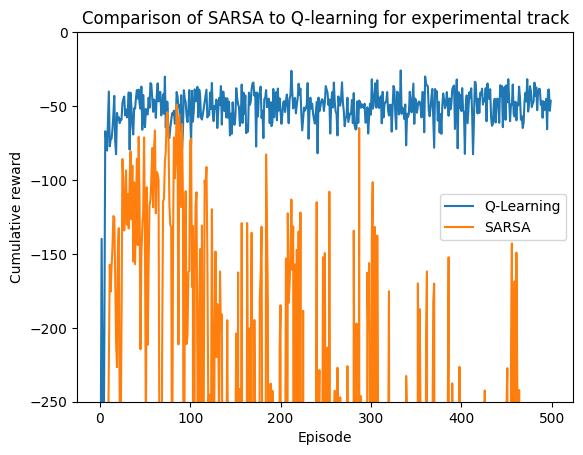

In [434]:
x = range(0, len(initial_sarsa_runs[0])) # 500
sarsa = np.average(np.asarray(initial_sarsa_runs), axis=0)
ql = np.average(np.asarray(initial_ql_runs), axis=0)

plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.title(f"Comparison of SARSA to Q-learning for experimental track")
plt.ylim(-250, 0)
plt.plot(x, ql, label="Q-Learning")
plt.plot(x, sarsa, label="SARSA")
plt.legend();

In [435]:
# the changed gridworld has a shorter path that has become available
changed_experimental_env = "exp_env2.txt"
env2 = Environment(changed_experimental_env)
env2.print_env()

1111111
1111111
1000001
1111111
s00000f


In [436]:
# change environment
exp_sarsa.change_env(env2)
exp_ql.change_env(env2)

In [437]:
# using the prior trained Q function, continue
#   with another 50 runs of 500 episodes each
_, exp_sarsa_runs = exp_sarsa.run(r=50, e=500)
_, exp_ql_runs = exp_ql.run(r=50, e=500)

In [438]:
np.asarray(initial_sarsa_runs).shape

(50, 500, 1)

In [439]:
np.asarray(exp_sarsa_runs).shape

(50, 500, 1)

In [440]:
# append these new 500 episodes to to the old ones
exp_sarsa_data = np.concatenate((initial_sarsa_runs, exp_sarsa_runs), axis=1)
exp_ql_data = np.concatenate((initial_ql_runs, exp_ql_runs), axis=1)

In [441]:
print(exp_sarsa_data.shape)
print(exp_ql_data.shape)

(50, 1000, 1)
(50, 1000, 1)


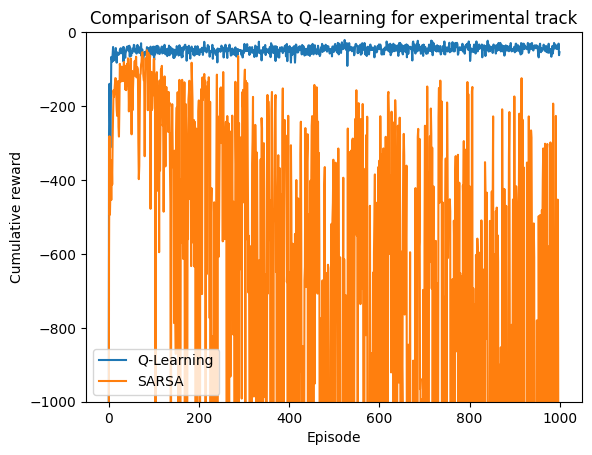

In [442]:
x = range(0, len(exp_sarsa_data[0])) # 500
sarsa = np.average(exp_sarsa_data, axis=0)
ql = np.average(exp_ql_data, axis=0)

plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.title(f"Comparison of SARSA to Q-learning for experimental track")
plt.ylim(-1000, 0)
plt.plot(x, ql, label="Q-Learning")
plt.plot(x, sarsa, label="SARSA")
plt.legend();

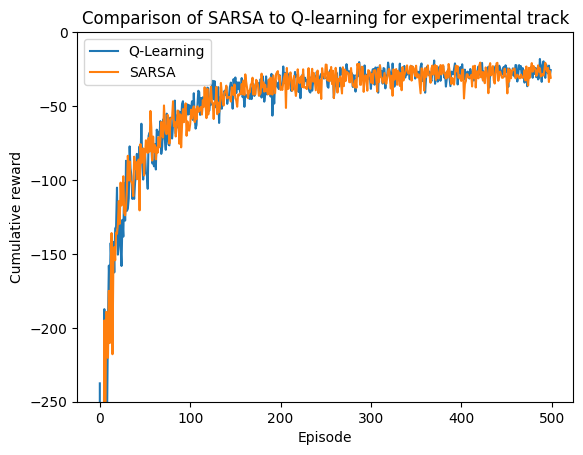

In [443]:
x = range(0, len(sarsa_exp_runs[0])) # 500
sarsa = np.average(np.asarray(sarsa_exp_runs), axis=0)
ql = np.average(np.asarray(ql_exp_runs), axis=0)

plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.title(f"Comparison of SARSA to Q-learning for experimental track")
plt.ylim(-250, 0)
plt.plot(x, ql, label="Q-Learning")
plt.plot(x, sarsa, label="SARSA")
plt.legend();

In [444]:
a1 = np.asarray([1,2,3,4])
a2 = np.asarray([5,6,7,8])
ac = np.concatenate((a1, a2), axis=0)
ac

array([1, 2, 3, 4, 5, 6, 7, 8])